In [1]:
# Library & Constants

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Options

XGB_FEATER_SELECTION = True
BINARY_CLASSIFICATION = True

# Paths

DATASET_DIR = './data'
MODEL_DIR = './models'

# Datsets Info

MAPPING_BINARY_LABELS = ['Benign', 'Malicious']
BINARY_LABELS = {
    0: 'Benign',
    1: 'Malicious'
}

MAPPING_MULTICLASS_LABELS = {
    0: 'Benign',
    1: 'Web Attack',
    2: 'DoS Attack',
    3: 'Network Attack',
    4: 'Botnet',
    5: 'Service Attack'
}
MULTICLASS_LABELS = {
    0: ['Benign'],
    1: ["Web_XSS", "Web_SQL_Injection", "Web_Brute_Force"],                                 # Web Attack
    2: ["DoS_Slowhttptest", "DoS_GoldenEye", "DDoS_LOIT", "DoS_Hulk", "DoS_Slowloris"],     # DoS Attack
    3: ["Port_Scan", "Heartbleed"],                                                         # Network Attack        
    4: ["Botnet_ARES"],                                                                     # Botnet
    5: ["SSH-Patator", "FTP-Patator"]                                                       # Service Attack                                           
}

# Dataset
Prima di procedere con la modellazione del dataset e alla creazione del modello, procediamo con il capire come i dati sono strutturati, cosa rappresentano e quali modifiche rapportare.

In [2]:
# Load Data

def load_data(datasets_dir: str) -> pd.DataFrame:
    """
    Load all datasets from a directory into a single DataFrame

    :param str datasets_dir: directory containing the datasets
    :return: pd.DataFrame containing all datasets
    """

    data = []
    for file in os.listdir(datasets_dir):
        if file.endswith('.csv'):
            data.append(pd.read_csv(os.path.join(datasets_dir, file)))

    return pd.concat(data, ignore_index=True)


if __name__ == '__main__':
    dataset = load_data(DATASET_DIR)    

## Data Exploration

Iniziamo l’analisi osservando la quantità di dati disponibili nel nostro dataset, BCCC-CIC-IDS2017, che comprende un totale impressionante di 2.438.052 record. Questi dati sono stati generati utilizzando NTLFlowLyzer, in contrasto con la versione precedente del dataset (CIC-IDS2017), che aveva invece adottato lo strumento CICFlowMeter per l'estrazione.

Per approfondire e comprendere meglio i dati a disposizione, esploriamoli graficamente per analizzarne la distribuzione e identificarne eventuali pattern significativi.

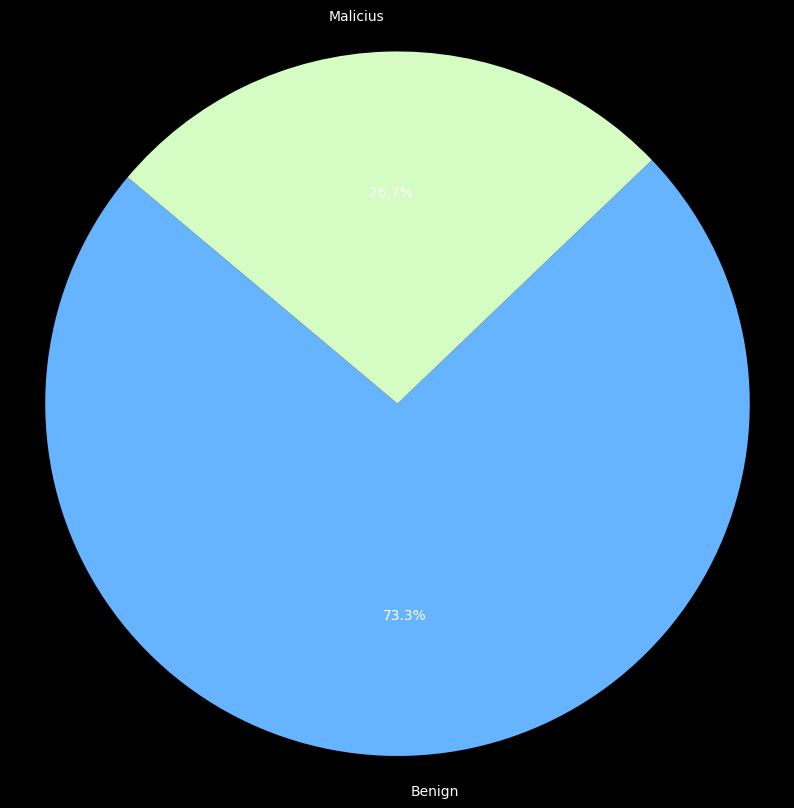

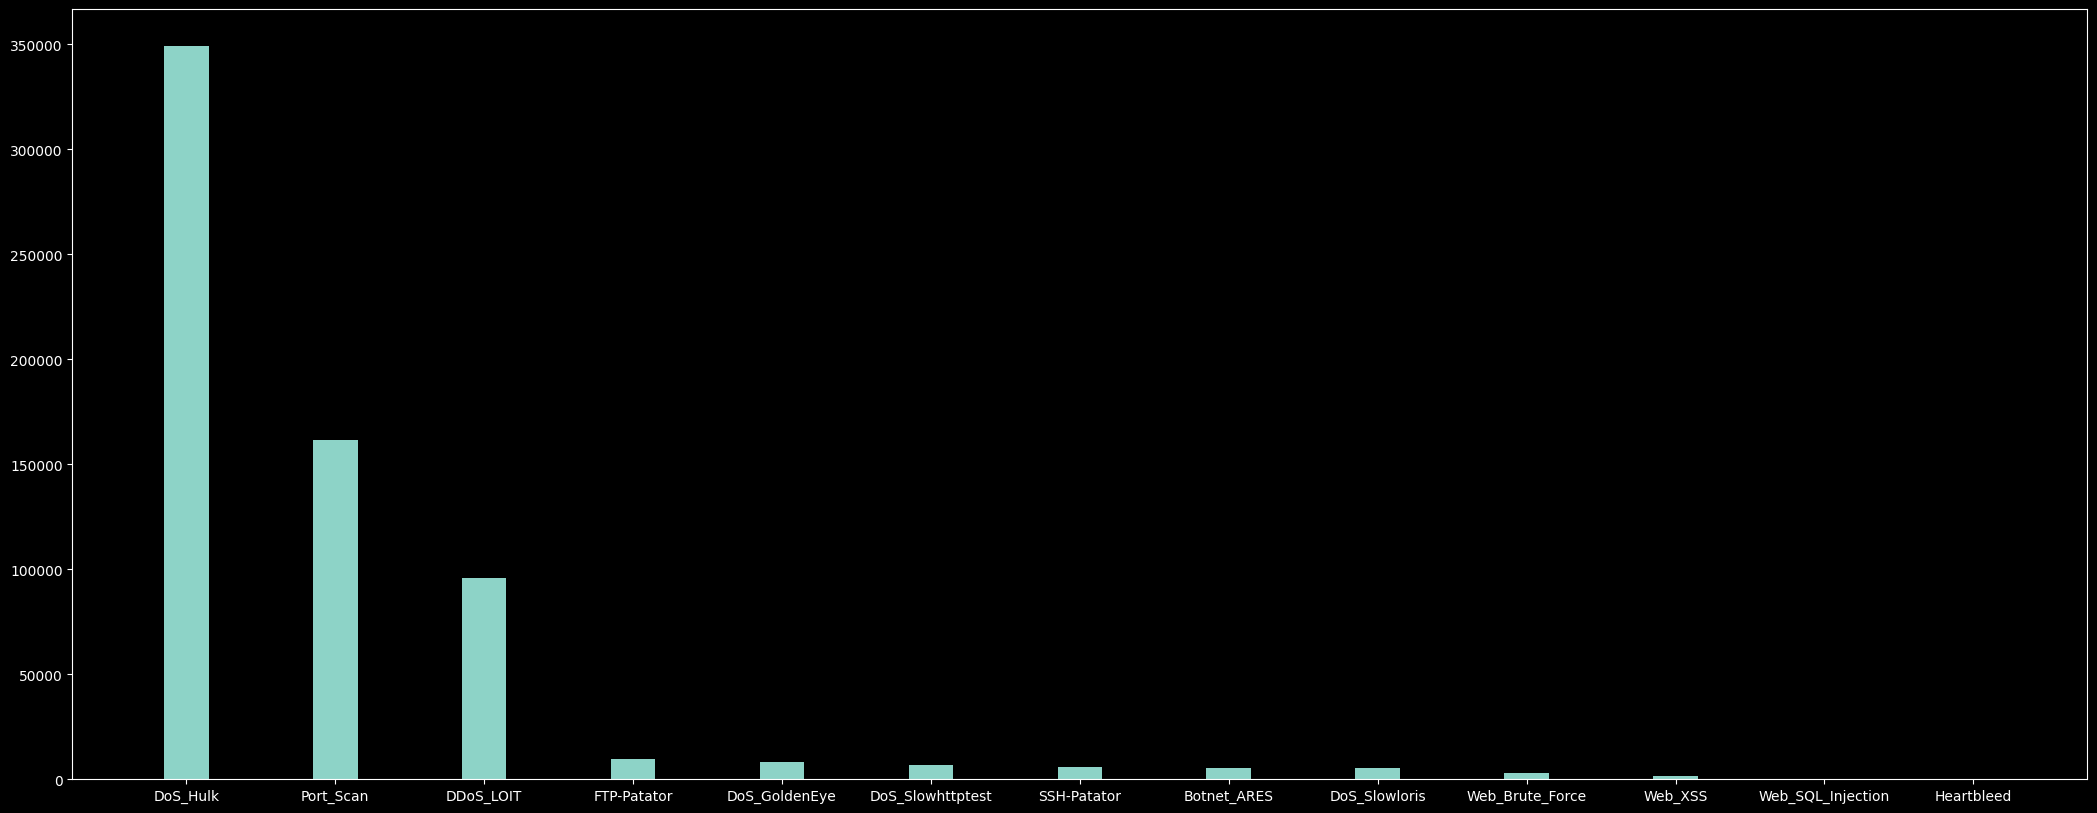

In [3]:
# Plot Data

def plot_attacks_distribution(target: pd.DataFrame):
    """
    Generates a bar chart to visualize the distribution of attack labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    """

    with plt.style.context('dark_background'):
        attack_data = dataset[~dataset['label'].isin(MAPPING_BINARY_LABELS)]['label'].value_counts()
        
        fig, ax = plt.subplots(figsize=(26, 10))
        ax.bar(attack_data.index, attack_data.values, width=0.3)
        plt.show()

    plt.close()
    

def plot_distribution(dataset: pd.DataFrame):
    """
    Generates a pie chart to visualize the distribution of 'Benign' and 'Attack' labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    """

    with plt.style.context('dark_background'):
        data = {
            'Benign': dataset['label'].isin(MAPPING_BINARY_LABELS).sum(),
            'Malicius': dataset[~dataset['label'].isin(MAPPING_BINARY_LABELS)]['label'].value_counts().sum()
        }
        plt.figure(figsize=(10, 10))
        plt.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#D4FCC3'])
        plt.axis('equal')
        plt.show()

    plt.close()


if __name__ == '__main__':
    plot_distribution(dataset)
    plot_attacks_distribution(dataset)

Dall'analisi dei dati emergono due osservazioni principali:
1. Il traffico normale è significativamente più rappresentato rispetto al traffico malevolo. Questo squilibrio può essere affrontato in modo intuitivo attraverso l’applicazione di tecniche di __undersampling__ sui dati relativi al traffico normale.
2. La distribuzione dei dati degli attacchi non è uniforme.

Concentrandoci sul secondo punto, l’alto sbilanciamento dei dati può influire negativamente sulle prestazioni del modello, aumentando il rischio di errori di predizione, soprattutto per le classi meno rappresentate. Per mitigare questo problema, è possibile adottare diversi approcci, ognuno con vantaggi e svantaggi:

- Escludere attacchi con pochi dati
- Applicare tecniche di undersampling e oversampling(undersampling).
- Focalizzarsi su un singolo tipo di attacco


_Per semplicità, procediamo con l'under sampling ed escludiamo il problema della distribuzione degli attacchi etichettando i dati solo con "Benign" e "Malicious"_

## Data Preparation

In [4]:
# Sampling data

def create_min_dataset_per_label(dataset: pd.DataFrame, target_column: str, min_count_per_class: int = 10) -> pd.DataFrame:
    """
    Creates a mini dataset containing exactly 10 records for each label.

    :param pd.DataFrame dataset: The original dataset.
    :param str target_column: The name of the column containing the target labels.
    :param int min_count_per_class: The number of records per label in the mini dataset.
    :return: A mini dataset with 10 records per label.
    """

    class_counts = dataset[target_column].value_counts()

    sampled_dfs = []

    for label in class_counts.index:
        # Ottieni un campione di massimo `min_count_per_class` record per ogni etichett
        sample_df = dataset[dataset[target_column] == label].sample(min_count_per_class, random_state=42)
        sampled_dfs.append(sample_df)

    # Concatenare tutti i dataframe per formare il mini dataset
    mini_dataset = pd.concat(sampled_dfs, axis=0)

    return mini_dataset


if __name__ == '__main__':
    mini_dataset = create_min_dataset_per_label(dataset, 'label')
    dataset = mini_dataset

In [5]:
# Data Cleaning
from typing import List

def clean_data(dataset: pd.DataFrame, columns_to_remove: List[str]) -> pd.DataFrame:
    """
    Cleans the given dataset.

    :param pd.DataFrame dataset: The dataset to clean.
    :param List[str] columns_to_remove: The columns to remove from the dataset.
    :return: The cleaned dataset.
    """

    dataset = dataset.dropna()
    dataset = dataset.drop_duplicates()

    float_cols = dataset.select_dtypes(include=['float']).columns
    dataset[float_cols] = dataset[float_cols].round(4)

    dataset = dataset.drop(columns=columns_to_remove)

    return dataset


if __name__ == '__main__':
    print("Before cleaning:")
    print(dataset.info())

    columns_to_remove = ["flow_id", "src_ip", "dst_ip", "src_port", "timestamp"]
    dataset = clean_data(dataset, columns_to_remove)

    print("\nAfter cleaning:")
    print(dataset.info())

Before cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 918124 to 1365
Columns: 122 entries, flow_id to label
dtypes: float64(61), int64(55), object(6)
memory usage: 134.5+ KB
None

After cleaning:
<class 'pandas.core.frame.DataFrame'>
Index: 140 entries, 918124 to 1365
Columns: 117 entries, dst_port to label
dtypes: float64(61), int64(54), object(2)
memory usage: 129.1+ KB
None


In [6]:
# Data Labeling

def binary_labeling(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Converts the 'label' column in the given dataset to binary labels.
    0 for benign and 1 for malicious.

    :param pd.DataFrame dataset: The dataset to convert.
    :return: The dataset with binary labels.
    """

    dataset['label'] = dataset['label'].apply(lambda x: 0 if x in MAPPING_BINARY_LABELS else 1)

    return dataset

def multiclass_labeling(dataset: pd.DataFrame, mapping_label: dict) -> pd.DataFrame:
    """
    Converts the 'label' column in the given dataset to multiclass labels.

    :param pd.DataFrame dataset: The dataset to convert.
    :param dict mapping_label: The mapping of labels to convert to.
    :return: The dataset with multiclass labels.
    """

    dataset['label'] = dataset['label'].map(mapping_label)
    return dataset


if __name__ == '__main__':
    print(f"Before {"Binary" if BINARY_CLASSIFICATION else 'Multiclass'} labeling:")
    print(dataset['label'].value_counts())

    if BINARY_CLASSIFICATION:
        dataset = binary_labeling(dataset)
    else:
        group_map = {attack: group for group, attacks in MULTICLASS_LABELS.items() for attack in attacks}
        dataset = multiclass_labeling(dataset, group_map)

    print(f"\nAfter {"Binary" if BINARY_CLASSIFICATION else 'Multiclass'} labeling:")
    print(f"\t[Mapping] {BINARY_LABELS if BINARY_CLASSIFICATION else MAPPING_MULTICLASS_LABELS}")
    print(dataset['label'].value_counts())

Before Binary labeling:
label
Benign               10
DoS_Hulk             10
Port_Scan            10
DDoS_LOIT            10
FTP-Patator          10
DoS_GoldenEye        10
DoS_Slowhttptest     10
SSH-Patator          10
Botnet_ARES          10
DoS_Slowloris        10
Web_Brute_Force      10
Web_XSS              10
Web_SQL_Injection    10
Heartbleed           10
Name: count, dtype: int64

After Binary labeling:
	[Mapping] {0: 'Benign', 1: 'Malicious'}
label
1    130
0     10
Name: count, dtype: int64


In [7]:
# Splitting Features and Labels
from typing import Tuple


def extract_feature_and_target(dataset: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Extracts the feature and target columns from the given dataset.

    :param pd.DataFrame dataset: The dataset to extract the feature and target columns from.
    :return: The feature and target columns.
    """

    return dataset.drop(columns=['label']), dataset['label']


if __name__ == '__main__':
    X, y = extract_feature_and_target(dataset)

    del dataset

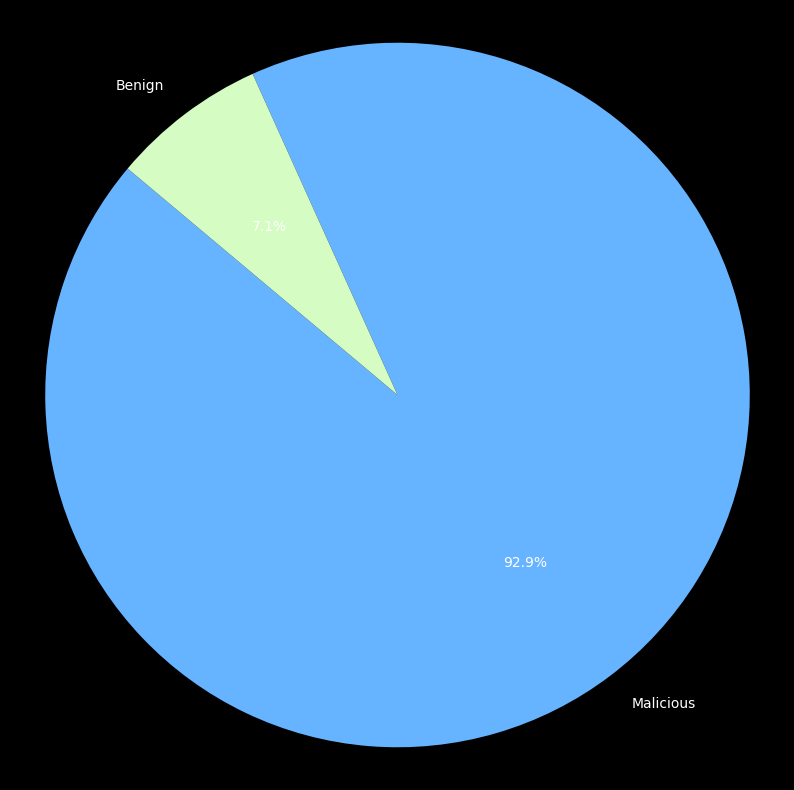

In [8]:
# Plotting before Data Balancing

def plot_attacks_distribution(target: pd.Series, mapping: list):
    """
    Generates a bar chart to visualize the distribution of attack labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    :param dict mapping: The mapping of labels to convert to.
    """

    with plt.style.context('dark_background'):
        attack_data = target.value_counts()
        attack_data.index = attack_data.index.map(mapping)

        fig, ax = plt.subplots(figsize=(26, 10))
        ax.bar(attack_data.index, attack_data.values, width=0.3)
        plt.show()

    plt.close()
    

def plot_distribution(target: pd.Series, mapping: dict):
    """
    Generates a pie chart to visualize the distribution of 'Benign' and 'Attack' labels in the given dataset.

    :param pd.DataFrame dataset: The dataset containing the 'label' column to generate the pie chart from.
    :param dict mapping: The mapping of labels to convert to.
    """

    with plt.style.context('dark_background'):
        data = target.value_counts()
        data.index = data.index.map(mapping)

        plt.figure(figsize=(10, 10))
        plt.pie(data.values, labels=data.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff', '#D4FCC3'])
        plt.axis('equal')
        plt.show()

    plt.close()


if __name__ == '__main__':    
    if BINARY_CLASSIFICATION:
        plot_distribution(y, BINARY_LABELS)
    else:
        plot_attacks_distribution(y, MAPPING_MULTICLASS_LABELS)

In [9]:
# Data Balancing

from imblearn.under_sampling import RandomUnderSampler

def balance_data_binary(dataset: pd.DataFrame, target: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Balances the given dataset using RandomUnderSampler.

    :param pd.DataFrame dataset: The dataset to balance.
    :param pd.Series target: The target column to balance.
    :return: The balanced dataset and target.
    """

    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(dataset, target)

    return X_resampled, y_resampled


if __name__ == '__main__':
    X, y = balance_data_binary(X, y)

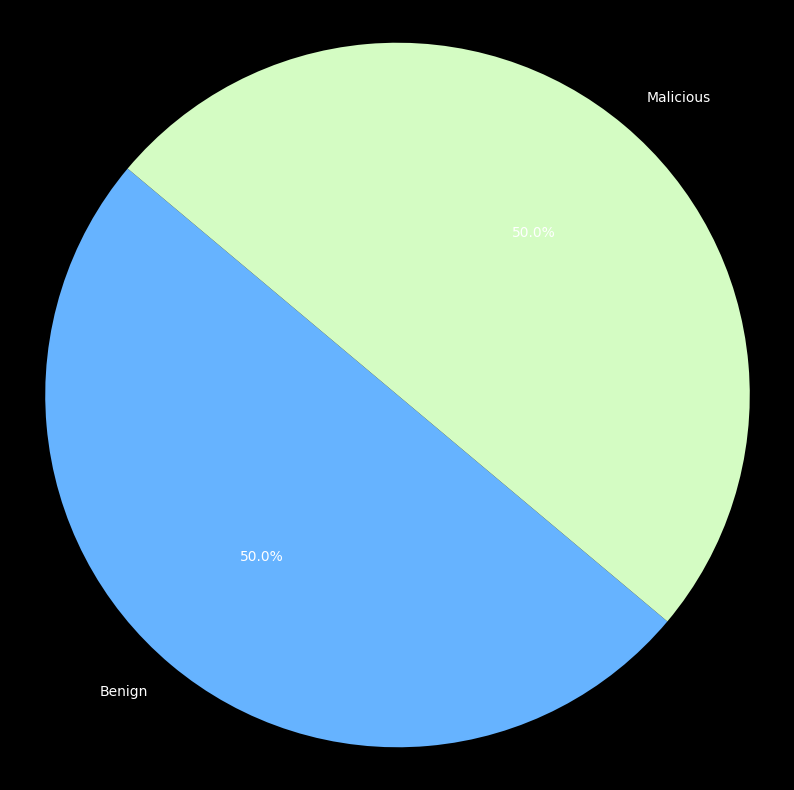

In [10]:
# Plotting after Data Balancing

if __name__ == '__main__':
    if BINARY_CLASSIFICATION:
        plot_distribution(y, BINARY_LABELS)
    else:
        plot_attacks_distribution(y, MAPPING_MULTICLASS_LABELS)

In [11]:
# One Hot Encoding
from sklearn.preprocessing import OneHotEncoder


def one_hot_encoding_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Applies one-hot encoding to all columns of type "object" in a pandas DataFrame.

    :param pd.DataFrame dataset: The DataFrame to apply one-hot encoding to.
    :return: The DataFrame with one-hot encoding applied.
    """

    object_columns = dataset.select_dtypes(include=['object']).columns

    encoder = OneHotEncoder(sparse_output=False)

    encoded_array = encoder.fit_transform(dataset[object_columns])
    encoded_columns = encoder.get_feature_names_out(object_columns)
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns)
    dataset = pd.concat(
        [dataset.drop(columns=object_columns).reset_index(drop=True), encoded_df.reset_index(drop=True)],
        axis=1
    )

    return dataset


if __name__ == '__main__':
    X = one_hot_encoding_dataset(X)

In [12]:
# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler


def normalize_data(dataset: pd.DataFrame) -> pd.DataFrame:
    """
    Normalizes the given dataset using Min-Max scaling.

    :param pd.DataFrame dataset: The dataset to normalize.
    :return: The normalized dataset.
    """

    scaler = MinMaxScaler()
    normalized_array = scaler.fit_transform(dataset)

    normalized_df = pd.DataFrame(normalized_array, columns=dataset.columns, index=dataset.index)
    return normalized_df

if __name__ == '__main__':
    X = normalize_data(X)

In [13]:
# Feature Selection

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


def select_features(dataset: pd.DataFrame, target: pd.Series, binary_classification: bool, threshold: float = 0.01, using_xgb: bool = True) -> pd.DataFrame:
    """
    Selects the most important features from the given dataset using a tree-based model.

    :param pd.DataFrame dataset: The dataset to select features from.
    :param pd.Series target: The target column.
    :param bool binary_classification: Whether the task is binary classification or not.
    :param float threshold: The threshold to use for feature selection.
    :param bool using_xgb: Whether to use XGBoost for feature selection or not.
    :return: The selected features.
    """

    if using_xgb:
        if binary_classification:
            clf = XGBClassifier(eval_metric='logloss', random_state=42, objective='binary:logistic')
        else:
            clf = XGBClassifier(eval_metric='mlogloss', random_state=42, objective='multi:softmax')
    else:
        clf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    clf.fit(dataset, target)
    feature_importances = clf.feature_importances_
    sfm = SelectFromModel(clf, threshold=threshold, prefit=True)
    selected_features = dataset.columns[sfm.get_support()]
    feature_scores = {feature: importance for feature, importance in zip(dataset.columns, feature_importances) if importance >= threshold}

    return selected_features, feature_scores


if __name__ == '__main__':
    features_name, features_scored = select_features(X, y, BINARY_CLASSIFICATION, using_xgb=XGB_FEATER_SELECTION)
    num_features = len(features_name)

    print(f"Selected features with threshold >= 0.01:")
    for feature, score in sorted(features_scored.items(), key=lambda x: x[1], reverse=True):
        print(f"\t{feature}\t{score:.4f}")

    X = X[features_name]


Selected features with threshold >= 0.01:
	fwd_mean_header_bytes		0.3481577932834625
	fwd_packets_IAT_min		0.12463434040546417
	dst_port		0.09782896935939789
	syn_flag_counts		0.08066459000110626
	fwd_packets_IAT_mean		0.07207261025905609
	fwd_ack_flag_counts		0.07070811092853546
	fwd_packets_IAT_total		0.06039860099554062
	packets_IAT_mean		0.039031293243169785
	bwd_packets_IAT_max		0.027090923860669136
	rst_flag_counts		0.023327570408582687
	duration		0.017976941540837288
	bwd_total_header_bytes		0.017360877245664597
	max_header_bytes		0.011554921977221966


# Modelling
Procederemo con lo sviluppo del modello facendo riferimento progetto github [_"Efficient-CNN-BiLSTMs"_](https://github.com/jayxsinha/Efficient-CNN-BiLSTM-for-Network-IDS/) per la sua struttura

In [14]:
# Data Splitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# The neural network model works only wiht numpy arrays, so we need to convert the dataframes to numpy arrays 
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Moreover, the neural network model has a specific input shape, so we need to reshape the data
X_train = X_train.reshape((-1, num_features, 1))
X_test = X_test.reshape((-1, num_features, 1))

del X, y

## Model Desing

I layer di questo modello sono i seguenti:
- CNN: Utile per apprendere le relazioni più nascoste tra le feature
- 2 BiLSTMs: Per poter capire come le feature hanno effetto su lungo raggio

In [15]:
# Model Design
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Bidirectional, LSTM, Reshape, Dropout, Dense, Activation

def build_model(input_shape=(122, 1)):
    model = Sequential()
    
    # 1D Convolutional layer
    model.add(Convolution1D(64, kernel_size=input_shape[0], padding="same", activation="relu", input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=5))
    model.add(BatchNormalization())
    
    # Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    
    # Reshape layer
    model.add(Reshape((128, 1), input_shape=(128,)))
    model.add(MaxPooling1D(pool_size=5))
    model.add(BatchNormalization())
    
    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(128, return_sequences=False)))
    
    # Dropout layer
    model.add(Dropout(0.5))
    
    # Dense output layer with sigmoid activation
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


if __name__ == '__main__':
    model = build_model(input_shape=(num_features, 1))

    print("Model Summary:")
    print(model.summary())

2024-12-13 16:29:54.776039: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 16:29:54.779424: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-13 16:29:54.787954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734103794.801960   11524 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734103794.806066   11524 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-13 16:29:54.820248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

Model Summary:


/home/suga/Desktop/IDS-AI/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1734103796.328979   11524 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/suga/Desktop/IDS-AI/venv/lib/python3.12/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in t

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 13, 64)         │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 25, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 1)          │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       133,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,581 (783.52 KB)

 Trainable params: 200,451 (783.01 KB)

 Non-trainable params: 130 (520.00 B)

None


In [16]:
# Model Training

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import KFold

def train_model(model, X_train, y_train, batch_size=32, epochs=10, validation_data=None):
    """
    Trains the given model.

    :param keras.models.Sequential model: The model to train.
    :param np.ndarray X_train: The training features.
    :param np.ndarray y_train: The training target.
    :param int batch_size: The batch size for training.
    :param int epochs: The number of epochs for training.
    :param Tuple[np.ndarray, np.ndarray] validation_data: The validation features and target.
    :return: The trained model and training history.
    """

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=validation_data
    )
    return model, history


if __name__ == '__main__':
    model, history = train_model(model, X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3750 - loss: 0.7025 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6875 - loss: 0.6854 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7500 - loss: 0.6723 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.7500 - loss: 0.6590 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8750 - loss: 0.6196 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.8750 - loss: 0.5966 - val_accuracy: 0.5000 - val_loss: 0.6925
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.8750 - loss: 0.5660 - val_accuracy: 0.5000 - val_loss: 0.6922
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9375 - loss: 0.5021 - val_accuracy: 0.5000 - val_loss: 0.6919
Ep

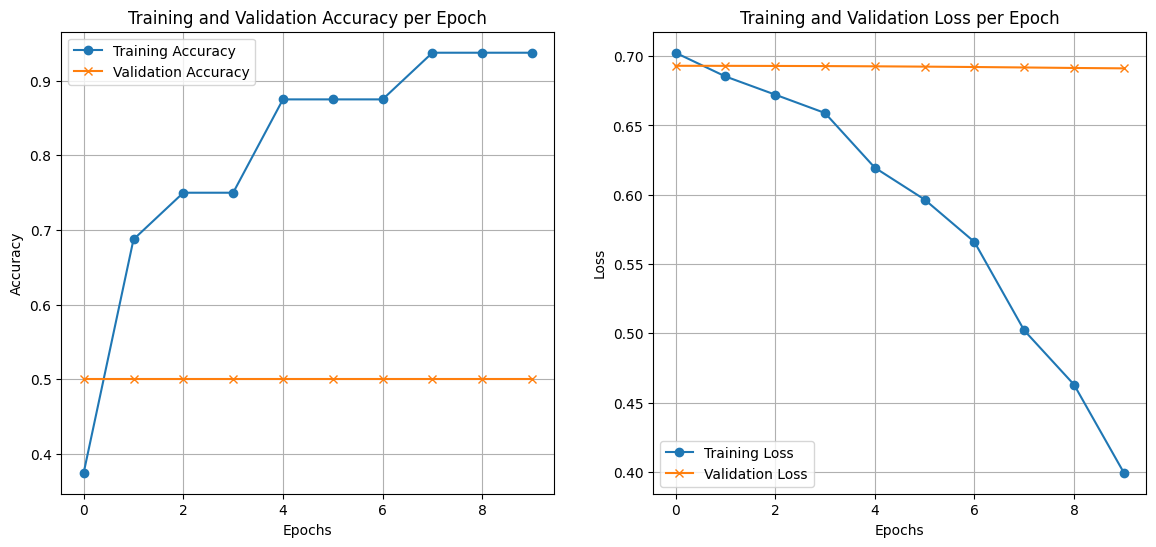

In [17]:
# Training Evaluation

def plot_training_metrics(history) -> plt.Figure:
    """
    Plots training and validation metrics from the history object.

    :param history: The training history object.
    :return: Matplotlib figure of the training metrics.
    """
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Accuracy Plot
    train_acc = history.history.get('accuracy', None)
    val_acc = history.history.get('val_accuracy', None)
    if train_acc and val_acc:
        ax[0].plot(train_acc, label='Training Accuracy', marker='o')
        ax[0].plot(val_acc, label='Validation Accuracy', marker='x')
        ax[0].set_title('Training and Validation Accuracy per Epoch')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Accuracy')
        ax[0].legend()
        ax[0].grid(True)

    # Loss Plot
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss', None)
    ax[1].plot(train_loss, label='Training Loss', marker='o')
    if val_loss:
        ax[1].plot(val_loss, label='Validation Loss', marker='x')
    ax[1].set_title('Training and Validation Loss per Epoch')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.show()
    plt.close()

    return fig


if __name__ == '__main__':
    plot_history = plot_training_metrics(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
Accuracy: 0.50
F1 Score (Weighted): 0.33


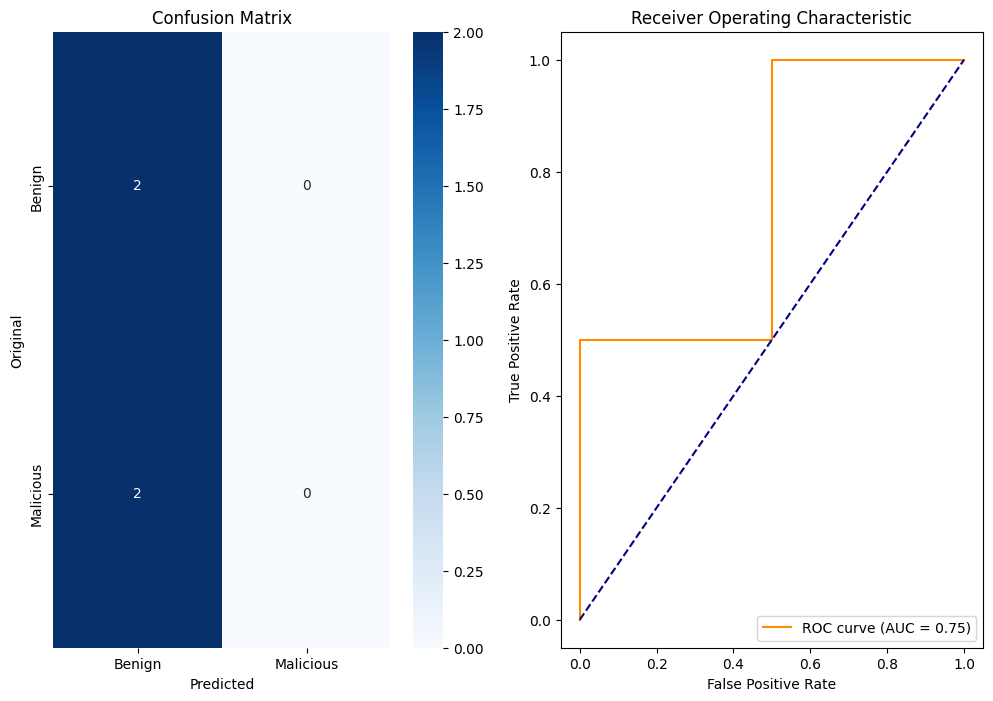

In [18]:
# Evaluation Metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, f1_score
import seaborn as sns

def plot_evaluation_metrics(y_test, y_pred, y_pred_probs, is_binary=True, target_mapping=None) -> plt.Figure:
    """
    Plots the confusion matrix and ROC curve for the given predictions.

    :param np.ndarray y_test: The true target labels.
    :param np.ndarray y_pred: The predicted target labels.
    :param np.ndarray y_pred_probs: The predicted target probabilities.
    :param bool is_binary: Whether the classification is binary or multiclass.
    :param dict target_mapping: The mapping of target labels.
    :return: Matplotlib figure of the evaluation metrics.
    """

    if is_binary:
        fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))

    if target_mapping:
        labels = [target_mapping.get(label, label) for label in np.unique(y_test)]
    else:
        labels = np.unique(y_test)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=labels, yticklabels=labels, 
                ax=axes[0] if is_binary else ax)
    
    if is_binary:
        axes[0].set_xlabel("Predicted")
        axes[0].set_ylabel("Original")
        axes[0].set_title("Confusion Matrix")
    else:
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Original")
        ax.set_title("Confusion Matrix")

    if is_binary:
        fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)
        axes[1].plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", color="darkorange")
        axes[1].plot([0, 1], [0, 1], color="navy", linestyle="--")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title("Receiver Operating Characteristic")
        axes[1].legend(loc="lower right")
        
    plt.show()
    plt.close()

    return fig

def evaluate_model(model, X_test, y_test, is_binary=True, target_mapping=None) -> plt.Figure:
    """
    Evaluates the given model using the test data and plots the evaluation metrics.

    :param keras.models.Sequential model: The trained model to evaluate.
    :param np.ndarray X_test: The test features.
    :param np.ndarray y_test: The test target.
    :param bool is_binary: Whether the classification is binary or multiclass.
    :param dict target_mapping: The mapping of target labels.
    :return: Matplotlib figure of the evaluation metrics.
    """


    if is_binary:
        y_pred_probs = model.predict(X_test).ravel()
        y_pred = (y_pred_probs >= 0.5).astype(int)
    else:
        y_pred_probs = model.predict(X_test)
        y_pred = np.argmax(y_pred_probs, axis=1)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"F1 Score (Weighted): {f1:.2f}")

    return plot_evaluation_metrics(y_test, y_pred, y_pred_probs, is_binary, target_mapping)


if __name__ == '__main__':
    plot_cm_and_roc = evaluate_model(model, X_test, y_test, is_binary=BINARY_CLASSIFICATION, target_mapping=BINARY_LABELS if BINARY_CLASSIFICATION else MAPPING_MULTICLASS_LABELS)

In [19]:
# Save Model
import json

def save_model(model, features: list, plots: dict, path: str = "models"):
    """
    Saves the given model, features, and plots to the specified path.

    :param keras.models.Sequential model: The model to save.
    :param list features: The list of features used by the model.
    :param dict plots: A dictionary of plots to save.
    :param str path: The path to save the model to.
    """

    if not os.path.exists(path):
        os.makedirs(path)

    version = len(os.listdir(path)) + 1
    model_dir = os.path.join(path, f"v{version}")

    os.makedirs(model_dir)

    # Save the model
    model.save(os.path.join(model_dir, "model.keras"))

    # Save the features as a JSON file
    with open(os.path.join(model_dir, "features.json"), "w") as f:
        json.dump(features, f, indent=4)

    # Save the plots
    for name, plot in plots.items():
        plot.savefig(os.path.join(model_dir, f"{name}.png"))


if __name__ == '__main__':
    figure_dict = {
        "plot_cm_and_roc": plot_cm_and_roc,
        "plot_history": plot_history    
    }

    save_model(model, list(features_name), figure_dict)
